In [2]:
import numpy as np
import pandas as pd
import scipy as sc
import math as mt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

In [3]:
data = pd.read_csv('co2-mauna-lua.csv')[:-1]
series = data['CO2 (ppm) mauna loa, 1965-1980'].astype('float64').values
date_labels = data['Month'].values
date = range(len(date_labels))

fit_series = series[:-30]
fit_date_labels = date_labels[:-30]

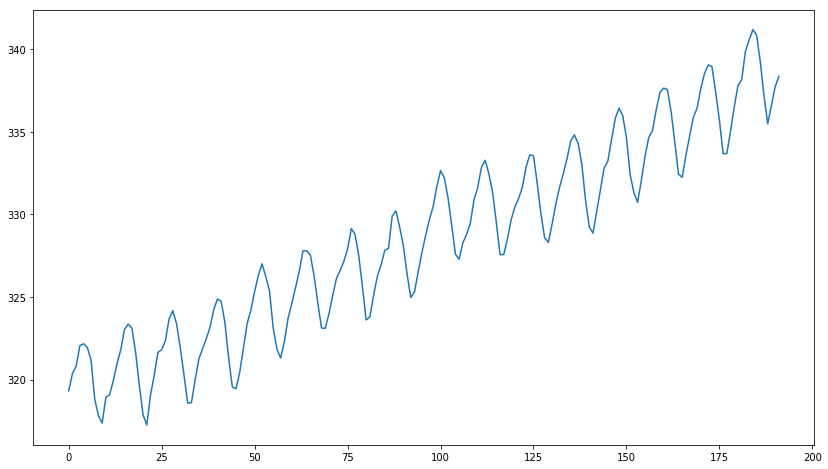

In [4]:
plt.figure(figsize=(14,8))
plt.plot(date, series);

# Базис Бернштейна

Построим аппроксисмацию данных на основе базисных многочленов вида:
    
$f(x) = \sum\limits_{k=1}^n a_kb_{n,k}(x)$,  где $b_{n,k}(x) = C_n^kx^k(1-x)^{n-k}$.


Пусть $A \, x = f$ - исходная переопределенная система,  $A^T \, A \, x = A^T \, f$ - каноническая система, которую мы разрешаем ($A^T=A^*$)

$A = \begin{pmatrix}
  (1-x_1)^n & nx_1(1-x_1)^{n-1} & \frac{n(n-1)}{2}x_1^2(1-x_1)^{n-2} & \dots & nx_1^{n-1}(1-x_1) & x_1^n \\
  \dots& \dots & \dots & \dots & \dots& \dots \\
  (1-x_r)^n & nx_r(1-x_r)^{n-1} & \frac{n(n-1)}{2}x_r^2(1-x_r)^{n-2} & \dots & nx_r^{n-1}(1-x_r) & x_r^n \\
\end{pmatrix}$, где $r$ - число записей в данных, $x_i$ - дата $i$-ого измерения

$f = \begin{pmatrix}
  f_1& \dots & f_r \\
\end{pmatrix}^T$, где $f_i$ - величина $i$-ого измерения.

Для осмысленности задачи, отложим последние три периода для проверки экстраполяции.

In [5]:
date1 = [x/192 for x in date]
fit_date1 = date1[:-30]

In [6]:
def get_A(x, n):
    return [mt.factorial(n)/(mt.factorial(k)*mt.factorial(n-k))*x**k*(1-x)**(n-k) for k in range(n+1)]

In [7]:
n = 3

A1 = np.matrix([get_A(x, n) for x in fit_date1])
f1 = np.transpose(np.matrix(fit_series))

ext_A1 = np.matrix([get_A(x, n) for x in date1])

In [8]:
tildeA1 = np.transpose(A1) * A1
tildef1 = np.transpose(A1) * f1

In [9]:
x1 = np.linalg.solve(tildeA1, tildef1)
approx_f1 = ext_A1 * x1

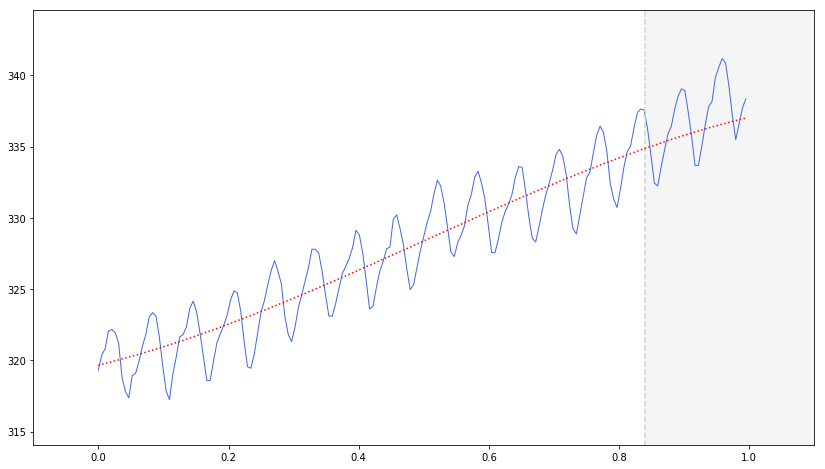

In [10]:
plt.figure(figsize=(14,8))
plt.plot(date1, series, color='royalblue', lw=1);
plt.plot([84.5*6/np.pi/192, 84.5*6/np.pi/192], [0, 500], 'k--', color = 'lightgrey')
plt.xlim(-0.1, 1.1)
plt.ylim((0.99*min(series), 1.01*max(series)))
plt.fill([84.5*6/np.pi/192, 84.5*6/np.pi/192, 150, 150], [0, 500, 500, 0], 'whitesmoke')
plt.plot(date1, approx_f1, 'k:', color='red', lw=1.5);

Наилучшая аппроксимация функции на отложенной выборке достигается при значении параметра базиса Бернштейна n = 3, поскольку базис Бернштейна хорошо приближает функцию на выбранном промежутке, но не предсказывает поведение функции вне этого промежутка. 

Рассмотрим _MSE_ на оптимизационной и отложенной выборках. 

In [11]:
print('Оптимизационная выборка: MSE = %0.3f' %mean_squared_error(approx_f1[:-30], fit_series))
print('Отложенная выборка: MSE = %0.3f' %mean_squared_error(approx_f1[-30:], series[-30:]))

Оптимизационная выборка: MSE = 3.968
Отложенная выборка: MSE = 5.134


In [12]:
np.linalg.cond(tildeA1)

126.6302204705232

Как видим базис Бернштейна дает далеко не наилучшую аппроксимацию функции, попробуем воспользоваться тригонометрической системой.

# Тригонометрическая система

$f(x) = \frac{a_0}{2} + \sum\limits_{k = 1}^n(a_kcos(kx) + b_ksin(kx))$

Пусть $A \, x = f$ - исходная переопределенная система,  $A^T \, A \, x = A^T \, f$ - каноническая система, которую мы разрешаем ($A^T=A^*$)

$A = \begin{pmatrix}
  \frac{1}{2} & sin(x_1) & \dots & sin(nx_1) & cos(x_1) & \dots & cos(nx_1) \\
  \dots& \dots & \dots & \dots & \dots& \dots & \dots  \\
  \frac{1}{2}& sin(x_r) & \dots & sin(nx_r) & cos(x_r) & \dots & cos(nx_r)
\end{pmatrix}$, где $r$ - число записей в данных, $x_i$ - дата $i$-ого измерения

$f = \begin{pmatrix}
  f_1& \dots & f_r \\
\end{pmatrix}^T$, где $f_i$ - величина $i$-ого измерения

In [13]:
date2 = [np.pi*x/192-np.pi/2 for x in date]
fit_date2 = date2[:-30]

In [14]:
def get_At(x, n):
    return [1/2] + [np.sin(k*x) for k in range(1,n+1)] + [np.cos(k*x) for k in range(1,n+1)]

In [15]:
n = 34

A2 = np.matrix([get_At(x, n) for x in fit_date2])
f2 = np.transpose(np.matrix(fit_series))

ext_A2 = np.matrix([get_At(x, n) for x in date2])

In [16]:
tildeA2 = np.transpose(A2) * A2
tildef2 = np.transpose(A2) * f2

In [17]:
x2 = np.linalg.solve(tildeA2, tildef2)
approx_f2 = ext_A2 * x2

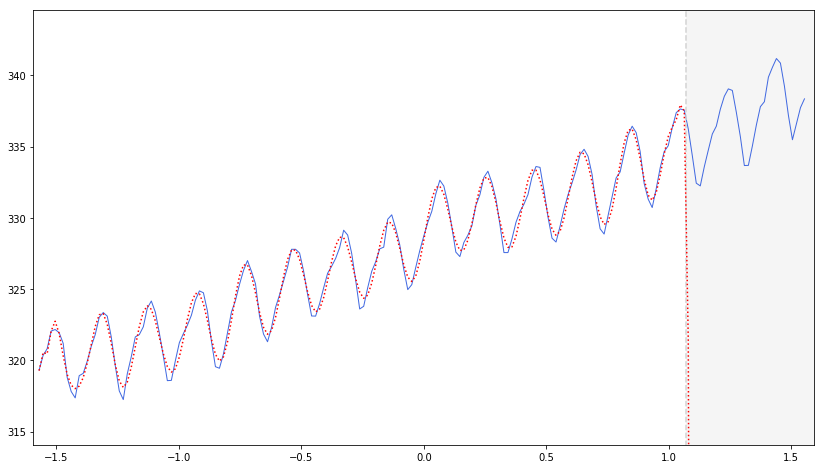

In [18]:
plt.figure(figsize=(14,8))
plt.plot(date2, series, color='royalblue', lw=1);
plt.plot([(np.pi*84.5*6/np.pi/192)-np.pi/2, (np.pi*84.5*6/np.pi/192)-np.pi/2], [0, 500], 'k--', color = 'lightgrey')
plt.xlim(-3.19/2, 3.19/2)
plt.ylim((0.99*min(series), 1.01*max(series)))
plt.fill([(np.pi*84.5*6/np.pi/192)-np.pi/2, (np.pi*84.5*6/np.pi/192)-np.pi/2, 150, 150], [0, 500, 500, 0], 'whitesmoke')
plt.plot(date2, approx_f2, 'k:', color='red', lw=1.5);

Рассмотрим _MSE_ на оптимизационной и отложенной выборках. 

In [19]:
print('Оптимизационная выборка: MSE = %0.3f' %mean_squared_error(approx_f2[:-30], fit_series))
print('Отложенная выборка: MSE = %0.3f' %mean_squared_error(approx_f2[-30:], series[-30:]))

Оптимизационная выборка: MSE = 0.283
Отложенная выборка: MSE = 23962312316738.121


In [20]:
np.linalg.cond(tildeA2)

1.418041395799821e+17

Отметим, что данные имеют ярко выраженную сезонность и тренд. Оценим период сезонности данной зависимости. 

$T = \frac{\text{отрезок оси}}{\text{число пиков}} = \frac{192}{16} = 12.0$

Зная, что ось проградирована по месяцам, то получили, что период равен полному году. Имеет место сезонность по годам, что вполне осмысленно. Отскалируем так, чтобы период был примерно равен $ 2\pi$.

In [21]:
date = [np.pi*x/6 for x in date]
fit_date = date[:-30]

_Общая идея:_ поскольку зависимость имеет явный тренд и выраженную сезонность, то она может быть аппроксимирована периодическими функциями вида $sin(kx)$, $cos(kx)$, отвечающими за сезонность, и многочленами вида $x^k$, отражающими тренд. 

Для осмысленности задачи, отложим последние три периода для проверки экстраполяции.

$f(x) = \sum \limits_{k=1}^n a_k \cdot sin(kx) + \sum \limits_{k=1}^n b_k \cdot cos(kx) + \sum \limits_{k=0}^m c_k \cdot x^k$

Пусть $A \, x = f$ - исходная переопределенная система,  $A^T \, A \, x = A^T \, f$ - каноническая система, которую мы разрешаем ($A^T=A^*$)

$A = \begin{pmatrix}
  1& x_1 & \dots & x_1^m & sin(x_1) & \dots & sin(nx_1) & cos(x_1) & \dots & cos(nx_1) \\
  \dots& \dots & \dots & \dots & \dots& \dots & \dots & \dots & \dots & \dots \\
  1& x_r & \dots & x_r^m & sin(x_r) & \dots & sin(nx_r) & cos(x_r) & \dots & cos(nx_r)
\end{pmatrix}$, где $r$ - число записей в данных, $x_i$ - дата $i$-ого измерения

$f = \begin{pmatrix}
  f_1& \dots & f_r \\
\end{pmatrix}^T$, где $f_i$ - величина $i$-ого измерения

In [22]:
def get_funcs(x, n, m):
    return [x**k for k in range(m+1)] + [np.sin(k*x) for k in range(1,n+2)] + [np.cos(k*x) for k in range(1,n+2)]

In [23]:
n = 3
m = 2

A = np.matrix([get_funcs(x, n, m) for x in fit_date])
f = np.transpose(np.matrix(fit_series))

ext_A = np.matrix([get_funcs(x, n, m) for x in date])

In [24]:
tildeA = np.transpose(A) * A
tildef = np.transpose(A) * f

In [25]:
x = np.linalg.solve(tildeA, tildef)
approx_f = ext_A * x

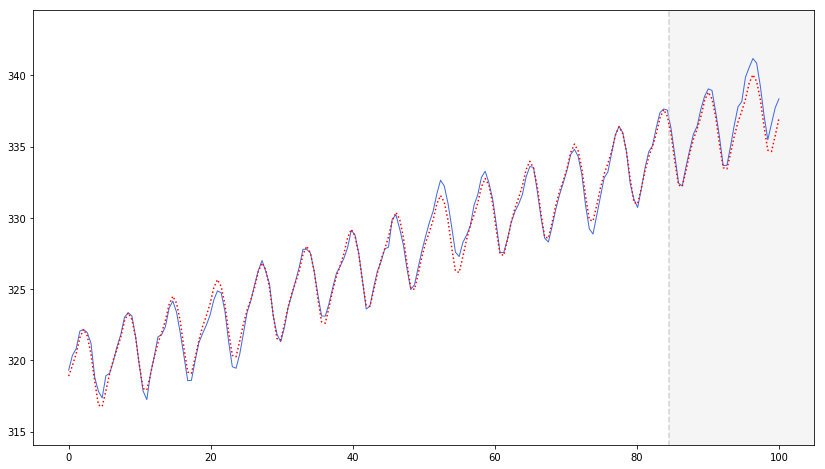

In [26]:
plt.figure(figsize=(14,8))
plt.plot(date, series, color='royalblue', lw=1);
plt.plot([84.5, 84.5], [0, 500], 'k--', color = 'lightgrey')
plt.fill([84.5, 84.5, 150, 150], [0, 500, 500, 0], 'whitesmoke')
plt.xlim(-5, 105)
plt.ylim((0.99*min(series), 1.01*max(series)))
plt.plot(date, approx_f, 'k:', color='red', lw=1.5);

Рассмотрим коэффициенты при базисных функциях

In [27]:
funcs = ['x^'+str(k) for k in range(m+1)] + \
        ['sin'+str(k)+'x' for k in range(1, n+1)] + \
        ['cos'+str(k)+'x' for k in range(1, n+1)]

coefs = [y.tolist()[0][0] for y in x]

func_coef = list(zip(funcs, coefs))
func_coef

[('x^0', 318.97486440843295),
 ('x^1', 0.18342940136045952),
 ('x^2', 6.242996651999271e-05),
 ('sin1x', 2.6213994456650225),
 ('sin2x', -0.6037841272487616),
 ('sin3x', -0.08524654921303382),
 ('cos1x', 0.07004231884681633),
 ('cos2x', -0.4371836520600079),
 ('cos3x', 0.3866004334282649)]

Рассмотрим _MSE_ на оптимизационной и отложенной выборках. 

In [28]:
print('Оптимизационная выборка: MSE = %0.3f' %mean_squared_error(approx_f[:-30], fit_series))
print('Отложенная выборка: MSE = %0.3f' %mean_squared_error(approx_f[-30:], series[-30:]))

Оптимизационная выборка: MSE = 0.227
Отложенная выборка: MSE = 0.752


In [33]:
np.linalg.cond(tildeA)

90387895.9249014

In [31]:
from math import inf